In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import json
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,ZeroPadding2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from keras.applications import VGG16
from os import listdir

In [25]:
train_folder = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/train'
val_folder = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/val'
import os


def get_number_of_data(folder):

  num_data = 0
  for file in os.listdir(folder):
    if os.path.isfile(os.path.join(folder, file)):
      num_data += 1

  return num_data


if __name__ == '__main__':
  num_train_data = get_number_of_data(train_folder)
  num_val_data = get_number_of_data(val_folder)

  print("There are {} training data.".format(num_train_data))
  print("There are {} validation data.".format(num_val_data))


There are 3072 training data.
There are 384 validation data.


In [3]:
def create_imagedatagenerator(train_folder, val_folder):
    

  train_datagen = ImageDataGenerator(
      preprocessing_function=keras.applications.mobilenet.preprocess_input)

  val_datagen = ImageDataGenerator(
      preprocessing_function=keras.applications.mobilenet.preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_folder,
      target_size=(256, 256),
      batch_size=32,
      class_mode='categorical')

  val_generator = val_datagen.flow_from_directory(
      val_folder,
      target_size=(256, 256),
      batch_size=32,
      class_mode='categorical')

  return train_generator, val_generator


if __name__ == '__main__':
  train_generator, val_generator = create_imagedatagenerator(
      train_folder, val_folder)

  for i in range(10):
    batch_x, batch_y = train_generator.next()

    print(batch_x.shape)
    print(batch_y.shape)


NameError: name 'keras' is not defined

In [26]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/train'
training_datagen = ImageDataGenerator(rescale=1./255)

VALIDATION_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/validation'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)


Found 3072 images belonging to 1 classes.
Found 384 images belonging to 1 classes.


In [27]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras.models import Model

# Create the base MobileNetV2 model with pre-trained weights from 'imagenet'
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the base model so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the top layers on the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)

# Create the classification output layer
classification_output = Dense(1, activation='sigmoid', name='classification')(x)

# Create the regression output layer
regression_output = Dense(4, activation='linear', name='regression')(x)

# Create the final model with multiple outputs
model = Model(inputs=base_model.input, outputs=[classification_output, regression_output])

# Display the model summary
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [6]:
from tensorflow.keras.optimizers import RMSprop

# Define the number of epochs
epochs = 10

# Create the RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss={'classification': 'binary_crossentropy', 'regression': 'mean_squared_error'},
    metrics={'classification': 'accuracy'}
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)


Epoch 1/10
42/96 [============>.................] - ETA: 24s - loss: 0.2766 - classification_loss: 0.0450 - regression_loss: 0.2316 - classification_accuracy: 0.9948

KeyboardInterrupt: 

In [ ]:
model.save('/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/fina files/mmodel.h5')

/////

In [2]:
import os
import numpy as np
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


2023-08-17 16:47:48.810061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/train'
training_datagen = ImageDataGenerator(rescale=1./255)

VALIDATION_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/validation'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)


Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [47]:
from keras.preprocessing.image import ImageDataGenerator
import os
import json

# Directory paths for training and validation data
TRAIN_JSON_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/train_json'
VALIDATION_JSON_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotations/val_json'

# Load true bounding box coordinates from training JSON files
train_true_bbox_list = []
for filename in os.listdir(TRAIN_JSON_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(TRAIN_JSON_DIR, filename), 'r') as json_file:
            data = json.load(json_file)
            bbox = data[0]['bbox']  # Extract the 'bbox' list from the first dictionary in the list
            x1, y1, x2, y2 = bbox
            train_true_bbox_list.append([x1, y1, x2, y2])

# Convert the list of true bounding boxes to a numpy array for training
train_true_bbox = np.array(train_true_bbox_list)


# Load true bounding box coordinates from validation JSON files
validation_true_bbox_list = []
for filename in os.listdir(VALIDATION_JSON_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(VALIDATION_JSON_DIR, filename), 'r') as json_file:
            data = json.load(json_file)
            bbox = data[0]['bbox']  # Extract the 'bbox' list from the first dictionary in the list
            x1, y1, x2, y2 = bbox
            validation_true_bbox_list.append([x1, y1, x2, y2])

# Convert the list of true bounding boxes to a numpy array for validation
validation_true_bbox = np.array(validation_true_bbox_list)

# Now you can use 'train_generator', 'train_true_bbox', 'validation_generator', and 'validation_true_bbox' for training and validation


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/train_json'

In [5]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input, Conv2D

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output  
# Add additional layers for object detection
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)

# Add classification and bounding box regression branches
class_output = Dense(1, activation='sigmoid', name='class_output')(x)  # Use 'sigmoid' for binary classification
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)     # 4 coordinates for bounding box

# Create the final model
model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

model.summary ()

2023-08-17 15:22:03.911266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

/// Classification

In [9]:
model.compile(optimizer='adam',
              loss={'class_output': 'binary_crossentropy'},
              metrics={'class_output': 'accuracy'})

history=model.fit(train_generator,
          epochs=7,
          steps_per_epoch=len(train_generator),
          validation_data=validation_generator,
          validation_steps=len(validation_generator))


Epoch 1/7
96/96 [==============================] - 59s 600ms/step - loss: 0.0123 - class_output_loss: 0.0123 - class_output_accuracy: 0.9919 - val_loss: 2.2264e-07 - val_class_output_loss: 2.2264e-07 - val_class_output_accuracy: 1.0000
Epoch 2/7
96/96 [==============================] - 45s 464ms/step - loss: 2.3220e-07 - class_output_loss: 2.3220e-07 - class_output_accuracy: 1.0000 - val_loss: 2.1091e-07 - val_class_output_loss: 2.1091e-07 - val_class_output_accuracy: 1.0000
Epoch 3/7
96/96 [==============================] - 45s 469ms/step - loss: 2.1847e-07 - class_output_loss: 2.1847e-07 - class_output_accuracy: 1.0000 - val_loss: 1.9674e-07 - val_class_output_loss: 1.9674e-07 - val_class_output_accuracy: 1.0000
Epoch 4/7
96/96 [==============================] - 45s 466ms/step - loss: 2.0263e-07 - class_output_loss: 2.0263e-07 - class_output_accuracy: 1.0000 - val_loss: 1.8113e-07 - val_class_output_loss: 1.8113e-07 - val_class_output_accuracy: 1.0000
Epoch 5/7
96/96 [===============

In [9]:
import matplotlib.pyplot as plt

In [13]:
# Save the trained model
model.save('/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/modelh5/classificationmodel.h5')


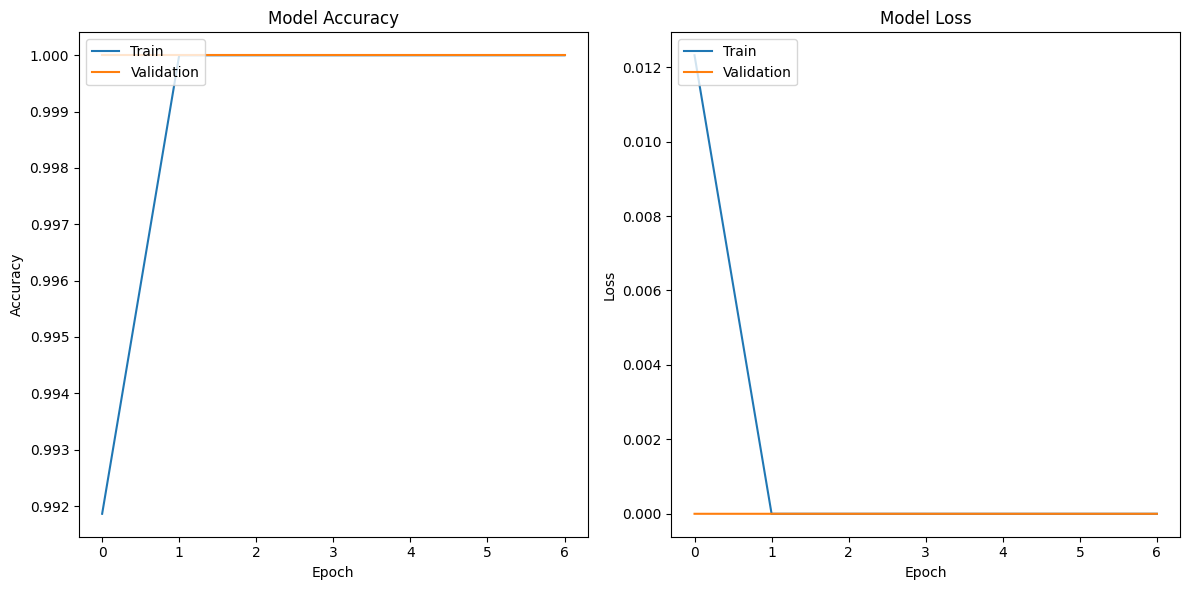

<Figure size 640x480 with 0 Axes>

In [12]:

# Save the trained model
model.save('/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/modelh5/classificationmodel.h5')

# Plot the training history graph
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history['val_class_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['class_output_loss'])
plt.plot(history.history['val_class_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

graph_path = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/graph.png'
plt.savefig(graph_path)

both

In [7]:
from keras.optimizers import Adam

# Compile the model for both classification and bounding box regression
model.compile(optimizer=Adam(),
              loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

# Train the entire model
history = model.fit(train_generator,
                    epochs=7,
                    steps_per_epoch=len(train_generator),
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator))


model.save('/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/modelh5/msebounding_box.h5')

Epoch 1/7
96/96 [==============================] - 61s 603ms/step - loss: 0.0059 - class_output_loss: 5.1807e-05 - bbox_output_loss: 0.0059 - class_output_accuracy: 1.0000 - bbox_output_mse: 0.0059 - val_loss: 0.0036 - val_class_output_loss: 1.7371e-05 - val_bbox_output_loss: 0.0036 - val_class_output_accuracy: 1.0000 - val_bbox_output_mse: 0.0036
Epoch 2/7
96/96 [==============================] - 58s 603ms/step - loss: 0.0029 - class_output_loss: 1.1770e-05 - bbox_output_loss: 0.0029 - class_output_accuracy: 1.0000 - bbox_output_mse: 0.0029 - val_loss: 0.0031 - val_class_output_loss: 7.6162e-06 - val_bbox_output_loss: 0.0031 - val_class_output_accuracy: 1.0000 - val_bbox_output_mse: 0.0031
Epoch 3/7
96/96 [==============================] - 68s 704ms/step - loss: 0.0024 - class_output_loss: 6.0397e-06 - bbox_output_loss: 0.0024 - class_output_accuracy: 1.0000 - bbox_output_mse: 0.0024 - val_loss: 0.0024 - val_class_output_loss: 4.6120e-06 - val_bbox_output_loss: 0.0024 - val_class_outp

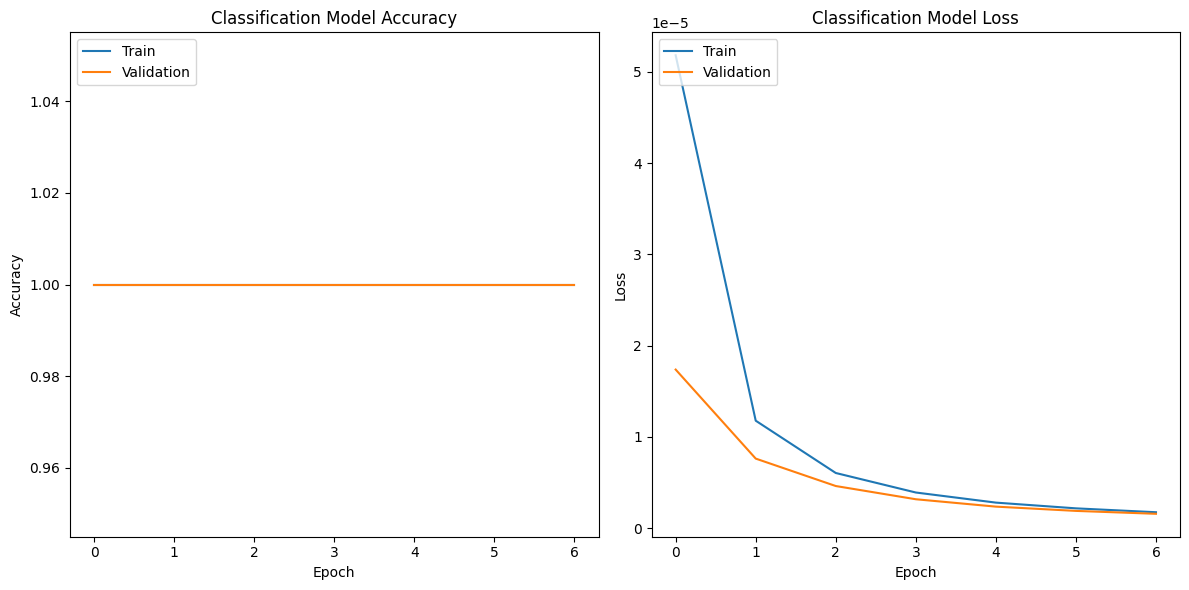

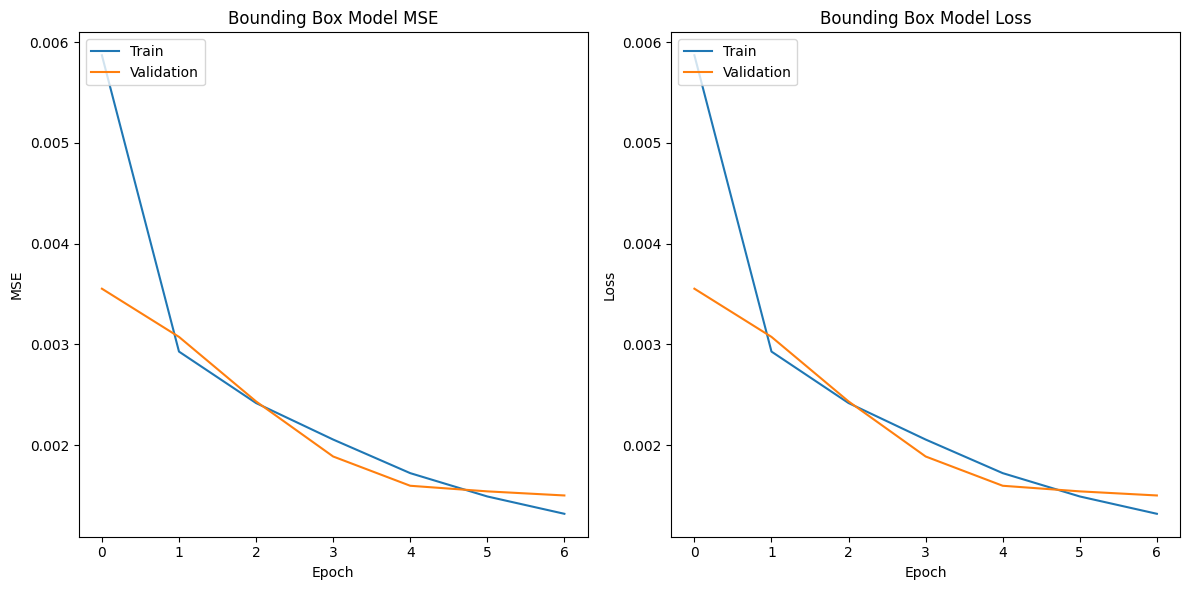

In [11]:
# Plot the training history graphs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values for classification
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history['val_class_output_accuracy'])
plt.title('Classification Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for classification
plt.subplot(1, 2, 2)
plt.plot(history.history['class_output_loss'])
plt.plot(history.history['val_class_output_loss'])
plt.title('Classification Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot training & validation mean squared error (MSE) values for bounding box regression
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['bbox_output_mse'])
plt.plot(history.history['val_bbox_output_mse'])
plt.title('Bounding Box Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for bounding box regression
plt.subplot(1, 2, 2)
plt.plot(history.history['bbox_output_loss'])
plt.plot(history.history['val_bbox_output_loss'])
plt.title('Bounding Box Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
class_graph_path = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/classification_graph.png'
plt.savefig(class_graph_path)
bbox_graph_path = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/bbox_graph.png'
plt.savefig(bbox_graph_path)

<Figure size 640x480 with 0 Axes>

In [16]:
import numpy as np
from sklearn.metrics import f1_score

# Load the test data and create the test generator
TEST_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/test'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

# Get the model's predictions on the test data
test_predictions = model.predict(test_generator)

# Get the predicted class labels and confidence scores
predicted_labels = (test_predictions[0] > 0.5).astype(int)
confidence_scores = test_predictions[0]

# Evaluate test accuracy
test_accuracy = np.mean(predicted_labels == test_generator.classes)
print('Test Accuracy:', test_accuracy)


Found 385 images belonging to 1 classes.


13/13 [==============================] - 9s 670ms/step
Test Accuracy: 1.0


In [17]:
from sklearn.metrics import precision_score, recall_score

# Load the test data and create the test generator
TEST_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/test'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

# Get the model's predictions on the test data
test_predictions = model.predict(test_generator)

# Get the predicted class labels and confidence scores
predicted_labels = (test_predictions[0] > 0.5).astype(int)
confidence_scores = test_predictions[0]

# Calculate precision and recall
precision = precision_score(test_generator.classes, predicted_labels, zero_division=1)
recall = recall_score(test_generator.classes, predicted_labels, zero_division=1)


print('Precision:', precision)
print('Recall:', recall)


Found 385 images belonging to 1 classes.
13/13 [==============================] - 8s 605ms/step
Precision: 1.0
Recall: 1.0


In [8]:
from keras.models import load_model

# Load the saved model
model = load_model('/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/modelh5/msebounding_box.h5')

# Print the model summary
model.summary()

# Now you can use the loaded_model for predictions, evaluation, etc.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import os
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the saved model
model_path = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/modelh5/msebounding_box.h5'
model = load_model(model_path)

# Directory paths for test data and JSON annotations
TEST_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/test'
JSON_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/test_json'

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    class_mode='sparse',
    classes=['meningioma'],
    batch_size=1  # Set batch_size to 1 for testing a single data point
)

# Get the model's predictions on the test data
test_predictions = model.predict(test_generator)

# Get the predicted class labels and confidence scores for classification
predicted_labels = (test_predictions[0] > 0.5).astype(int)
confidence_scores = test_predictions[0]

# Calculate precision, recall, and F1-score
precision = precision_score(test_generator.classes, predicted_labels, zero_division=1)
recall = recall_score(test_generator.classes, predicted_labels, zero_division=1)
f1 = f1_score(test_generator.classes, predicted_labels, zero_division=1)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Get the predicted bounding box coordinates for regression
predicted_bbox = test_predictions[1]

# Load true bounding box coordinates from JSON files
true_bbox_list = []
for filename in os.listdir(JSON_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(JSON_DIR, filename), 'r') as json_file:
            data = json.load(json_file)
            bbox = data[0]['bbox']  # Extract the 'bbox' list from the first dictionary in the list
            x1, y1, x2, y2 = bbox
            true_bbox_list.append([x1, y1, x2, y2])

# Convert the list of true bounding boxes to a numpy array
true_bbox = np.array(true_bbox_list)


# Calculate Mean Squared Error (MSE) for bounding box regression
mse_bbox = np.mean((predicted_bbox - true_bbox)**2)

print('Mean Squared Error (MSE) for Bounding Box Regression:', mse_bbox)


Found 385 images belonging to 1 classes.
385/385 [==============================] - 14s 31ms/step
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Mean Squared Error (MSE) for Bounding Box Regression: 18029.063543107368


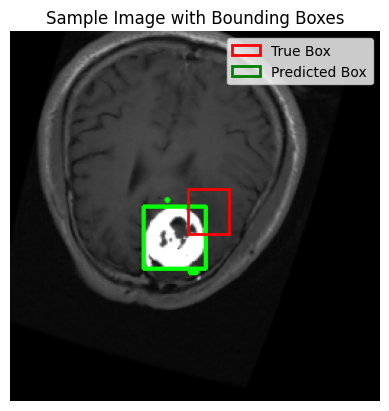

Intersection over Union (IoU): 0.0


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Select a random index for a sample from the test data
sample_index = np.random.randint(0, len(test_generator))

# Load the image and bounding box coordinates for the selected sample
image, _ = test_generator[sample_index]
true_bbox_sample = true_bbox[sample_index]
predicted_bbox_sample = predicted_bbox[sample_index]

# Plot the image with the true bounding box and predicted bounding box
plt.imshow(image[0])
plt.title('Sample Image with Bounding Boxes')
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((true_bbox_sample[0], true_bbox_sample[1]), 
                                   true_bbox_sample[2] - true_bbox_sample[0], 
                                   true_bbox_sample[3] - true_bbox_sample[1], 
                                   linewidth=2, edgecolor='r', facecolor='none', label='True Box'))
plt.gca().add_patch(plt.Rectangle((predicted_bbox_sample[0], predicted_bbox_sample[1]), 
                                   predicted_bbox_sample[2] - predicted_bbox_sample[0], 
                                   predicted_bbox_sample[3] - predicted_bbox_sample[1], 
                                   linewidth=2, edgecolor='g', facecolor='none', label='Predicted Box'))
plt.legend()
plt.show()
# Calculate Intersection over Union (IoU)
def calculate_iou(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2

    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bbox1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    bbox2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    iou = intersection_area / (bbox1_area + bbox2_area - intersection_area)
    return iou

# Calculate IoU for the sample
iou = calculate_iou(true_bbox_sample, predicted_bbox_sample)

print('Intersection over Union (IoU):', iou)




In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load a sample image from the test data
sample_image_path = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/test/aug_0_2631.png'  # Replace with the actual path of a sample image
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Get the predicted bounding box coordinates for the sample image
sample_predicted_bbox = model.predict(np.expand_dims(sample_image / 255.0, axis=0))[1]

# Calculate the coordinates of the predicted bounding box
x1, y1, x2, y2 = sample_predicted_bbox[0]

# Plot the sample image with the predicted bounding box
plt.figure(figsize=(8, 8))
plt.imshow(sample_image)
plt.title('Sample Image with Predicted Bounding Box')
plt.axis('off')

# Add the bounding box rectangle to the plot
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
plt.gca().add_patch(rect)

# Show the plot
plt.show()


In [8]:
import keras.backend as K

def iou_metric(y_true, y_pred):
    # Calculate IoU for bounding box regression
    intersection = K.sum(K.minimum(y_true, y_pred))
    union = K.sum(K.maximum(y_true, y_pred))
    
    # Handle cases where intersection or union is zero
    iou = K.switch(K.equal(union, 0), 0.0, intersection / union)
    
    return iou


# Compile the model for bounding box regression with IoU metric
model.compile(optimizer=Adam(),
              loss={'bbox_output': 'mean_squared_error'},
              metrics={'bbox_output': iou_metric})

# Train the bounding box regression branch with IoU metric
bbox_history = model.fit(train_generator,
                         epochs=7,
                         steps_per_epoch=len(train_generator),
                         validation_data=validation_generator,
                         validation_steps=len(validation_generator))

# Save the trained model
model.save('/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/modelh5/model_bounding_box.h5')


Epoch 1/7
96/96 [==============================] - 56s 558ms/step - loss: 1.0451e-08 - bbox_output_loss: 1.0451e-08 - bbox_output_iou_metric: -270.8673 - val_loss: 2.7587e-12 - val_bbox_output_loss: 2.7587e-12 - val_bbox_output_iou_metric: -0.4050
Epoch 2/7
96/96 [==============================] - 57s 591ms/step - loss: 7.3963e-13 - bbox_output_loss: 7.3963e-13 - bbox_output_iou_metric: -5.2172 - val_loss: 3.3678e-16 - val_bbox_output_loss: 3.3678e-16 - val_bbox_output_iou_metric: -1.3768
Epoch 3/7
96/96 [==============================] - 66s 688ms/step - loss: 3.9910e-17 - bbox_output_loss: 3.9910e-17 - bbox_output_iou_metric: -1.5773 - val_loss: 2.0107e-20 - val_bbox_output_loss: 2.0107e-20 - val_bbox_output_iou_metric: -0.0781
Epoch 4/7
96/96 [==============================] - 57s 595ms/step - loss: 1.9975e-21 - bbox_output_loss: 1.9975e-21 - bbox_output_iou_metric: -2.9230 - val_loss: 8.3815e-25 - val_bbox_output_loss: 8.3815e-25 - val_bbox_output_iou_metric: -4.9153
Epoch 5/7
96/9

In [25]:
import numpy as np
from sklearn.metrics import f1_score

# Load the test data and create the test generator
TEST_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/test'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

# Get the model's predictions on the test data
test_predictions = model.predict(test_generator)

# Get the predicted class labels and confidence scores
predicted_labels = (test_predictions[0] > 0.5).astype(int)
confidence_scores = test_predictions[0]

# Evaluate test accuracy
test_accuracy = np.mean(predicted_labels == test_generator.classes)
print('Test Accuracy:', test_accuracy)


Found 385 images belonging to 1 classes.


13/13 [==============================] - 7s 512ms/step
Test Accuracy: 1.0


In [27]:
from sklearn.metrics import precision_score, recall_score

# Load the test data and create the test generator
TEST_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/test'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

# Get the model's predictions on the test data
test_predictions = model.predict(test_generator)

# Get the predicted class labels and confidence scores
predicted_labels = (test_predictions[0] > 0.5).astype(int)
confidence_scores = test_predictions[0]

# Calculate precision and recall
precision = precision_score(test_generator.classes, predicted_labels, zero_division=1)
recall = recall_score(test_generator.classes, predicted_labels, zero_division=1)


print('Precision:', precision)
print('Recall:', recall)


Found 385 images belonging to 1 classes.


13/13 [==============================] - 7s 533ms/step
Precision: 1.0
Recall: 1.0
